# ****Importing all required python libraries****

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import PIL.Image as Image 
from pathlib import Path

from glob import glob
import pandas as pd
import os


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Flatten
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras import layers


# **Importing the Pre-trained InceptionV3 CNN model**

In [4]:
IMAGE_SIZE = [224,224] # Resize the size of all images 
Inception = InceptionV3(input_shape = IMAGE_SIZE +[3], weights = 'imagenet',include_top = False)

2022-05-04 08:03:23.223305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 08:03:23.311472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 08:03:23.312186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 08:03:23.313292: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [5]:
# Loading our custom skin disease dataset
train_path = '../input/basedir/base_dir/train_dir'
valid_path = '../input/basedir/base_dir/val_dir'

# **Process of re-training the model with the dataset**

In [6]:
# Not training the existing weights
for layer in Inception.layers:
  layer.trainable = False

In [7]:
# Get the list of all classes 
folders = glob('../input/basedir/base_dir/train_dir/*')
folders

['../input/basedir/base_dir/train_dir/mel',
 '../input/basedir/base_dir/train_dir/vasc',
 '../input/basedir/base_dir/train_dir/df',
 '../input/basedir/base_dir/train_dir/nv',
 '../input/basedir/base_dir/train_dir/bkl',
 '../input/basedir/base_dir/train_dir/akiec',
 '../input/basedir/base_dir/train_dir/bcc']

In [8]:
x = Flatten()(Inception.output)

prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs = Inception.input, outputs = prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
## Tell the model what cost and otimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [11]:
## Data Augmentation

train_datagen = ImageDataGenerator(rescale= 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale= 1./255)


training_set = train_datagen.flow_from_directory('../input/basedir/base_dir/train_dir',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = train_datagen.flow_from_directory('../input/basedir/base_dir/val_dir',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [12]:
training_set.class_indices # Labels the list of classes


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# **Creating Callback**

In [14]:
filepath = 'my_best_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# **Fitting the model**

In [15]:
r = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 20,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set),
    callbacks=callbacks   
)

2022-05-04 08:34:25.332143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-04 08:34:29.800038: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2411/2411 [==============================] - 677s 277ms/step - loss: 5.7485 - accuracy: 0.5611 - val_loss: 3.6918 - val_accuracy: 0.8337

Epoch 00001: loss improved from inf to 5.74854, saving model to my_best_model.h5
Epoch 2/20
2411/2411 [==============================] - 528s 219ms/step - loss: 5.7392 - accuracy: 0.6424 - val_loss: 4.3177 - val_accuracy: 0.7846

Epoch 00002: loss improved from 5.74854 to 5.73919, saving model to my_best_model.h5
Epoch 3/20
2411/2411 [==============================] - 533s 221ms/step - loss: 5.7924 - accuracy: 0.6671 - val_loss: 5.9773 - val_accuracy: 0.6994

Epoch 00003: loss did not improve from 5.73919
Epoch 4/20
2411/2411 [==============================] - 532s 220ms/step - loss: 5.2774 - accuracy: 0.6948 - val_loss: 3.5721 - val_accuracy: 0.8390

Epoch 00004: loss improved from 5.73919 to 5.27736, saving model to my_best_model.h5
Epoch 5/20
2411/2411 [==============================] - 530s 220ms/step - loss: 5.4880 - accuracy: 0.7009 - val_loss:

In [16]:
score = model.evaluate(test_set)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

59/59 [==============================] - 18s 309ms/step - loss: 4.9558 - accuracy: 0.8369
accuracy: 83.69%


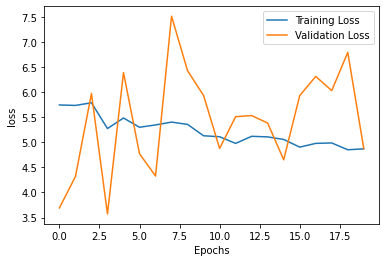

In [17]:
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.savefig('model_training_history')
plt.show()

In [28]:
new_model = load_model("./my_best_model.h5")

def classify(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)

    print(decode_predictions(prediction, top=3)[0])

classify("../input/actinic/ACTINIC-KERATOSES.jpg")

img_path = "../input/actinic/ACTINIC-KERATOSES.jpg"
plt.imshow(img)
plt.show()

In [29]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [31]:
score = new_model.evaluate(test_set)
print("%s: %.2f%%" % (new_model.metrics_names[1], score[1]*100))

59/59 [==============================] - 18s 308ms/step - loss: 7.3534 - accuracy: 0.7537
accuracy: 75.37%


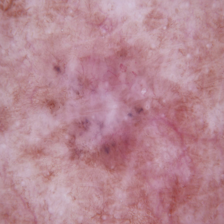

In [41]:
disease = Image.open("../input/basedir/base_dir/val_dir/bcc/ISIC_0031245.jpg").resize(IMAGE_SIZE)
disease

In [46]:
disease = np.array(disease)/255.0
disease.shape

(224, 224, 3)

In [48]:
disease[np.newaxis, ...]

array([[[[0.62745098, 0.41960784, 0.43529412],
         [0.62745098, 0.39607843, 0.39215686],
         [0.63137255, 0.41960784, 0.4       ],
         ...,
         [0.69019608, 0.56470588, 0.60784314],
         [0.71764706, 0.56862745, 0.60784314],
         [0.71764706, 0.56470588, 0.6       ]],

        [[0.63921569, 0.46666667, 0.50196078],
         [0.63137255, 0.41960784, 0.43137255],
         [0.61176471, 0.39607843, 0.38039216],
         ...,
         [0.71372549, 0.58039216, 0.61960784],
         [0.70980392, 0.55686275, 0.59607843],
         [0.70196078, 0.55686275, 0.58431373]],

        [[0.6627451 , 0.50196078, 0.53333333],
         [0.67058824, 0.47843137, 0.49019608],
         [0.62745098, 0.41176471, 0.41176471],
         ...,
         [0.71764706, 0.58039216, 0.61960784],
         [0.71372549, 0.56078431, 0.6       ],
         [0.70196078, 0.55294118, 0.58823529]],

        ...,

        [[0.6745098 , 0.50588235, 0.53333333],
         [0.6745098 , 0.50588235, 0.5372549 ]

In [49]:
result = new_model.predict(disease[np.newaxis, ...])
result.shape

(1, 7)

In [50]:
image_labels = []
with open("../input/list-of-diseases/skin diseases.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels

["1. Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)",
 '2. basal cell carcinoma (bcc)',
 '3. benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)',
 '4. dermatofibroma (df)',
 '5. melanoma (mel)',
 '6. melanocytic nevi (nv) ',
 '7. vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).']

In [51]:
predicted_label_index = np.argmax(result)
predicted_label_index

1

In [52]:
image_labels[predicted_label_index]


'2. basal cell carcinoma (bcc)'